# Challenge 2.1.8

Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far.

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.

### Question:  Can we predict whether or not a kickstarter project will fail or succeed?

The dataset I've chosen includes over 350,000 Kickstarter projects started on Kickstarter between 2009 and 2016.

Outcome variable: state

Variables: backers, goal, launched, deadline, pledged, main category, country

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('datafiles/ks-projects-201801.csv', encoding='iso-8859-1')

In [3]:
# Taking a peek at what the dataset looks like
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 03:43:57,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 13 columns):
ID               378661 non-null int64
name             378659 non-null object
category         378661 non-null object
main_category    378661 non-null object
currency         378661 non-null object
deadline         378661 non-null object
goal             378661 non-null float64
launched         378661 non-null object
pledged          378661 non-null float64
state            378661 non-null object
backers          378661 non-null int64
country          378661 non-null object
usd pledged      374864 non-null float64
dtypes: float64(3), int64(2), object(8)
memory usage: 37.6+ MB


There are 13 columns with a total of 378,661 data points.  

### Exploratory Data Analysis

In [5]:
df['main_category'].value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


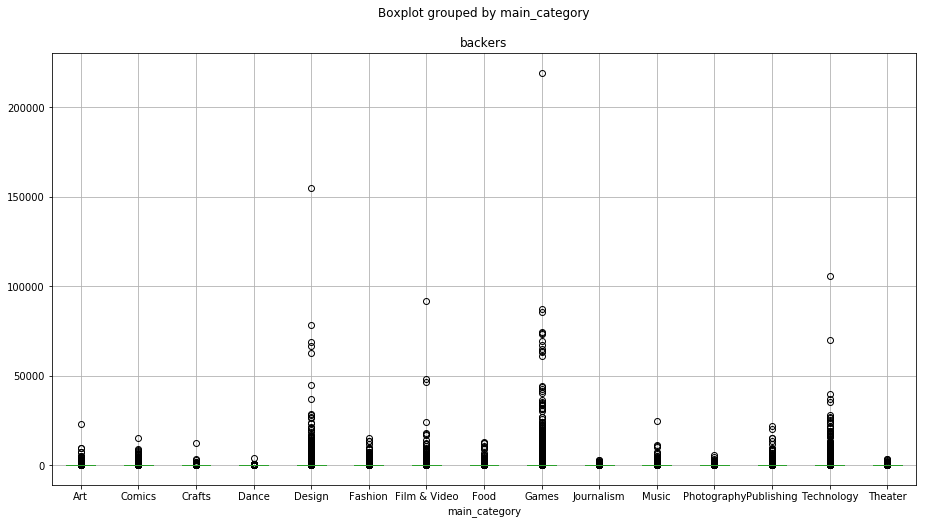

In [6]:
df.boxplot('backers', by='main_category', figsize=(15,8))

You can't even see the boxplots... This indicates that most projects in all categories don't really get off the ground.  We would also need to make a feature that log transforms the data to do more efficient analysis.

#### Logged features
Logging columns goals, backers and pledged for easier analysis.
Adding 1 to avoid NAs when logging 0. 

In [7]:
df['log_goal'] = df['goal'].apply(lambda x: np.log(x+1)) 
df['log_backers'] = df['backers'].apply(lambda x: np.log(x+1)) 
df['log_pledged'] = df['pledged'].apply(lambda x: np.log(x+1)) 

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


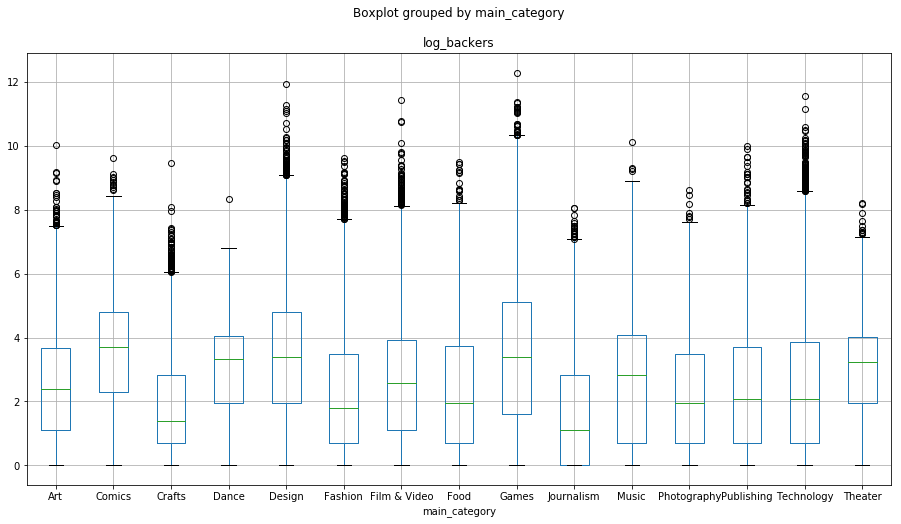

In [8]:
df.boxplot('log_backers', by='main_category', figsize=(15,8))

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


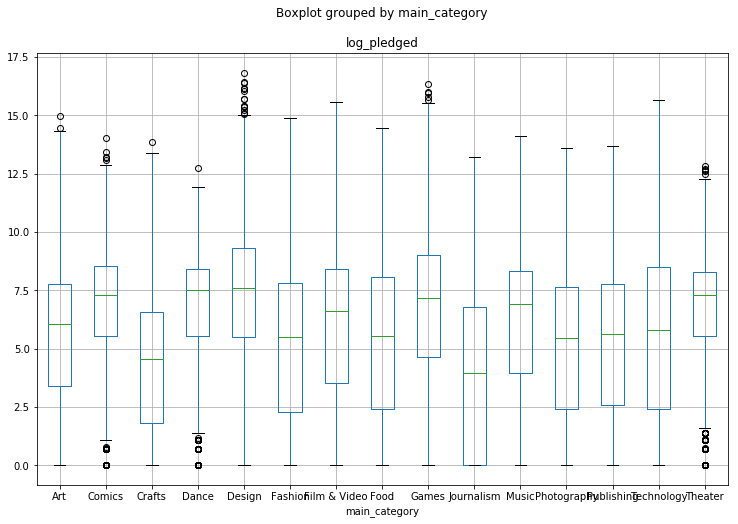

In [9]:
df.boxplot('log_pledged', by='main_category', figsize=(12,8))

In [10]:
# Taking a sample of the first 50,000 data points to generate plots.
df1 = df.loc[:50000,['log_goal','log_backers','log_pledged']].dropna()

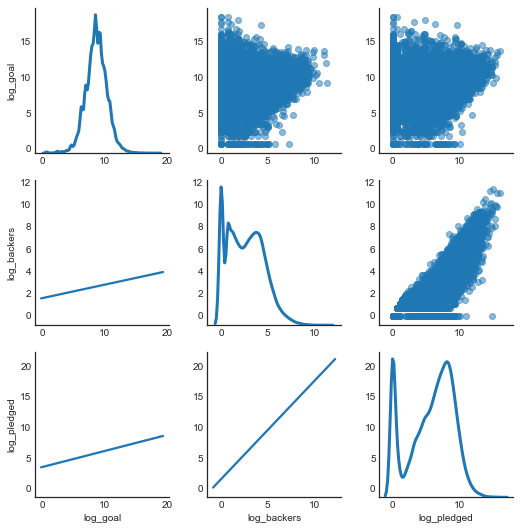

In [11]:
sns.set_style('white')

g = sns.PairGrid(df1, diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)

plt.show()

             log_goal  log_backers  log_pledged
log_goal     1.000000     0.109393     0.135572
log_backers  0.109393     1.000000     0.916775
log_pledged  0.135572     0.916775     1.000000


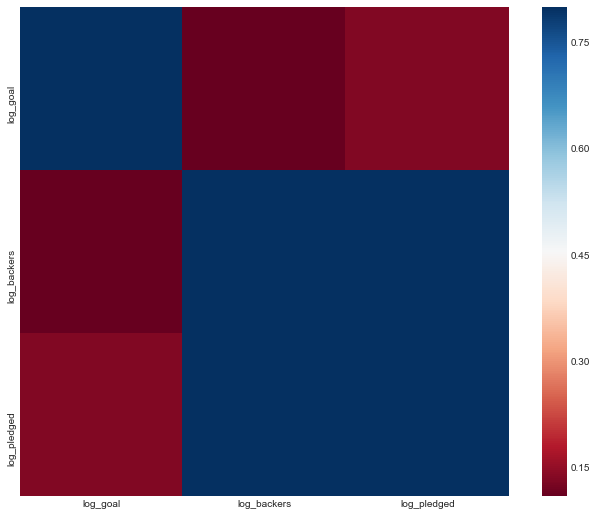

In [12]:
corrmat = df1.corr()
print(corrmat)

#Set up matplotlib
f, ax = plt.subplots(figsize=(12,9))

# Heatmap of correlation matrix
sns.heatmap(corrmat, vmax=.8, square=True, cmap="RdBu")

plt.show()

Not surprisingly, backers and amount pledged are positively correlated with one another.  Goals does not seem to be correlated with backers or amount pledged.

#### Success Feature
Categorizing 'Successful' states as 1 and "failed","canceled",and "suspended" as 0.

In [13]:
# Creating our dataset to for analysis
df_success = df.loc[
    ((df['state'] == 'successful') | (df['state'] == 'failed') | (df['state'] == 'canceled') | (df['state'] == 'suspended') ), 
    ['ID', 'name', 'main_category','currency','deadline','goal','launched','pledged','state','backers','country']
]
df_success.head()

,ID,name,main_category,currency,deadline,goal,launched,pledged,state,backers,country
0,1000002330,The Songs of Adelaide & Abullah,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01 03:43:57,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US
2,1000004038,Where is Hank?,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US


In [14]:
df_success['state'].value_counts()

failed        197719
successful    133956
canceled       38779
suspended       1846
Name: state, dtype: int64

In [15]:
df_success['success'] = df_success.state.apply(lambda x: 1 if x == 'successful' else 0)

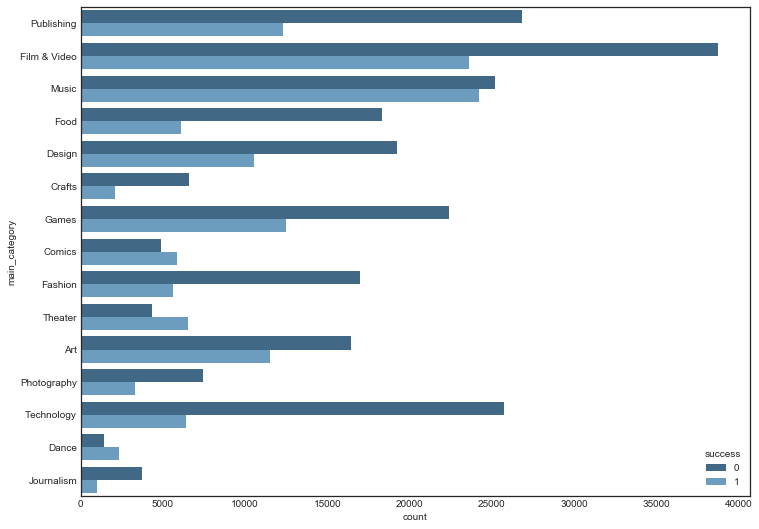

In [16]:
#Set up matplotlib
f, ax = plt.subplots(figsize=(12,9))

sns.countplot(y='main_category', hue='success', data=df_success, palette='Blues_d')

plt.show()

In [17]:
# Table of counts
counttable = pd.crosstab(df_success['main_category'], df_success['success'])
print(counttable)

success            0      1
main_category              
Art            16449  11510
Comics          4901   5842
Crafts          6618   2115
Dance           1411   2338
Design         19213  10550
Fashion        16970   5593
Film & Video   38776  23623
Food           18333   6085
Games          22425  12518
Journalism      3712   1012
Music          25206  24197
Photography     7425   3305
Publishing     26813  12300
Technology     25755   6434
Theater         4337   6534


#### Currency Feature

The Goal and Pledged column is listed in different currencies.  Let's convert them all into USD.  
Conversion rates are based on rates on January 24, 2018.

In [18]:
df['currency'].unique()

array(['GBP', 'USD', 'CAD', 'AUD', 'NOK', 'EUR', 'MXN', 'SEK', 'NZD',
       'CHF', 'DKK', 'HKD', 'SGD', 'JPY'], dtype=object)

In [19]:
df.currency.value_counts()

USD    295365
GBP     34132
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64

In [20]:
# Creating a dictionary for conversions
convert = {'GBP':0.7, 'USD':1.0, 'CAD':1.23, 'AUD':1.24, 'NOK':7.75, 'EUR':0.81, 'MXN':18.49, 'SEK':7.93, 'NZD':1.35,
       'CHF':0.95, 'DKK':6.00, 'HKD':7.82, 'SGD':1.31, 'JPY':109.09}

# Turning dictionary into a dataframe
df = pd.DataFrame.from_dict(convert, orient='index')
df.columns = ['conversion_rate']

df.head()

,conversion_rate
NOK,7.75
MXN,18.49
JPY,109.09
EUR,0.81
USD,1.00


In [21]:
# Testing one country conversion
country = 'CAD'
amount_to_convert = 100

# Example urrency conversion of 100 CAD to USD
cad_in_usd = amount_to_convert * df.loc[country, 'conversion_rate']
print(cad_in_usd)

123.0


In [22]:
# Create a list of the conversions for each country
new_conv_list = []
for row in df_success.itertuples():
    new_conv_list.append(df.loc[row.currency, 'conversion_rate'])

In [23]:
# Create a new column with the conversion rate and goals converted 
df_success['conversion_rate'] = new_conv_list
df_success['goal_usd'] = df_success['goal'] * df_success['conversion_rate']

In [24]:
# Create a new column with pledged converted
df_success['pledged_usd'] = df_success['pledged'] * df_success['conversion_rate']

In [25]:
df_success.head()

,ID,name,main_category,currency,deadline,goal,launched,pledged,state,backers,country,success,conversion_rate,goal_usd,pledged_usd
0,1000002330,The Songs of Adelaide & Abullah,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0,0.7,700.0,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01 03:43:57,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,0,1.0,30000.0,2421.0
2,1000004038,Where is Hank?,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,0,1.0,45000.0,220.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,0,1.0,5000.0,1.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,0,1.0,19500.0,1283.0


#### Percent Funded feature
This feature calculates the percentage of the goal that was funded.

In [26]:
df_success['percent_funded'] = (df_success['pledged'] / df_success['goal']).round(4)

In [27]:
df_success.head()

,ID,name,main_category,currency,deadline,goal,launched,pledged,state,backers,country,success,conversion_rate,goal_usd,pledged_usd,percent_funded
0,1000002330,The Songs of Adelaide & Abullah,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0,0.7,700.0,0.0,0.0000
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01 03:43:57,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,0,1.0,30000.0,2421.0,0.0807
2,1000004038,Where is Hank?,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,0,1.0,45000.0,220.0,0.0049
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,0,1.0,5000.0,1.0,0.0002
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,0,1.0,19500.0,1283.0,0.0658


#### Average pledged
This feature calculates the average pledge amount per back for the project.

In [28]:
df_success['avg_pledged'] = (df_success['pledged'] / df_success['backers']).round(2)

#### Average donation needed
This feature calculates how much each backer would have needed to donate for the project to reach its goal.

In [29]:
df_success['avg_need'] = (df_success['goal'] / df_success['backers']).round(2)

#### Length of time
The feature calculates how long the project was active by subtracting the launch date from the deadline.

In [30]:
# Converting columns to datetime.

df_success['deadline'] = pd.to_datetime(df_success['deadline']).dt.date

df_success['launched'] = pd.to_datetime(df_success['launched']).dt.date

In [31]:
df_success['proj_time'] = df_success['deadline'] - df_success['launched']

In [32]:
# Converting proj_time into an int of days.
from datetime import datetime, timedelta

df_success['proj_time'] = df_success['proj_time'] / timedelta (days = 1)

#### Amount to be raised each day
This feature calculates the amount of money the project needs to raise given the project's length of timeto reach its goal.

In [33]:
df_success['amt_day'] = (df_success['goal'] / df_success['proj_time']).round(2)

In [34]:
df_success.head()

,ID,name,main_category,currency,deadline,goal,launched,pledged,state,backers,country,success,conversion_rate,goal_usd,pledged_usd,percent_funded,avg_pledged,avg_need,proj_time,amt_day
0,1000002330,The Songs of Adelaide & Abullah,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0,0.7,700.0,0.0,0.0000,NaN,inf,59.0,16.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,0,1.0,30000.0,2421.0,0.0807,161.40,2.000000e+03,60.0,500.00
2,1000004038,Where is Hank?,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,0,1.0,45000.0,220.0,0.0049,73.33,1.500000e+04,45.0,1000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,0,1.0,5000.0,1.0,0.0002,1.00,5.000000e+03,30.0,166.67
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,canceled,14,US,0,1.0,19500.0,1283.0,0.0658,91.64,1.392860e+03,56.0,348.21


#### Main Category features
Making dummies!  Also, aggregating some of the main categories

In [36]:
df_success['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [37]:
# Creating a dataframe to hold our features
features = pd.get_dummies(df_success['main_category'])

# Dummy variables for main categories
features['Arts'] = np.where((df_success['main_category'].isin(['Art', 'Photography','Theater','Dance'])), 1, 0)
features['Print'] = np.where((df_success['main_category'].isin(['Publishing', 'Journalism','Comics'])), 1, 0)
features['Craft'] = np.where((df_success['main_category'].isin(['Food', 'Crafts'])), 1, 0)
features['Film'] = np.where((df_success['main_category'].isin(['Film & Video'])), 1, 0)
features['Design'] = np.where((df_success['main_category'].isin(['Design','Technology','Fashion'])), 1, 0)
features['Music'] = np.where((df_success['main_category'].isin(['Music'])), 1, 0)
features['Games'] = np.where((df_success['main_category'].isin(['Games'])), 1, 0)